# Spindles-SO coupling

Replicate the analysis done in Fig 2A of [Winer et al. 2019](https://www.jneurosci.org/content/39/32/6315)

In [1]:
import mne
import yasa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks', font_scale=1.2)

# Load EEG data
f = np.load('data_full_6hrs_100Hz_Cz+Fz+Pz.npz')
data, ch_names = f['data'], f['chan']
sf = 100.
times = np.arange(data.size) / sf

# Keep only Cz
data = data[0, :].astype(np.float64)
print(data.shape, np.round(data[0:5], 3))

(2161058,) [15.797 22.307 39.922 25.657 27.094]


In [2]:
# Load the hypnogram data
hypno = np.loadtxt('data_full_6hrs_100Hz_hypno_30s.txt').astype(int)
print(hypno.shape, 'Unique values =', np.unique(hypno))

# Upsample to data
hypno = yasa.hypno_upsample_to_data(hypno=hypno, sf_hypno=1/30, data=data, sf_data=sf)

(720,) Unique values = [0 1 2 3 4]


d:\git\yasa\yasa\hypno.py:168: UserWarning: Hypnogram is SHORTER then data by 10.58 seconds. Padding hypnogram (with last value) to match data.size.
  'data.size.' % dur_diff)


## Spindles-locked analyses

**Spindles**

In [3]:
sp = yasa.spindles_detect(data, sf, hypno, include=(2, 3), remove_outliers=True)
print(sp.shape)
sp.head()

(486, 12)


,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Stage
0,585.54,586.09,586.38,0.84,59.682744,13.334660,2.256629,0.475648,12.957519,10.0,0.647059,2
1,598.09,598.62,599.52,1.43,79.858324,16.234394,2.377198,0.424400,12.888586,19.0,0.368056,2
2,604.37,604.73,605.08,0.71,60.636707,12.874629,2.222283,0.355090,12.648408,9.0,0.500000,2
3,655.06,655.50,655.86,0.80,47.939197,10.889576,2.148836,0.369696,13.328633,11.0,0.543210,2
4,725.60,726.50,726.88,1.28,77.591328,18.836009,2.370011,0.288164,12.369699,15.0,0.697674,2


In [4]:
# Get data centered around the most prominent peak of each spindle
events = yasa.get_sync_events(data, sf, detection=sp, center='Peak', time_before=1, time_after=1)
events

,Time,Event,Amplitude
0,-1.00,0,-26.614866
1,-0.99,0,-26.710604
2,-0.98,0,-29.008289
3,-0.97,0,-21.062124
4,-0.96,0,-21.445072
...,...,...,...
97681,0.96,485,-10.818273
97682,0.97,485,-0.574422
97683,0.98,485,3.638003
97684,0.99,485,2.010475


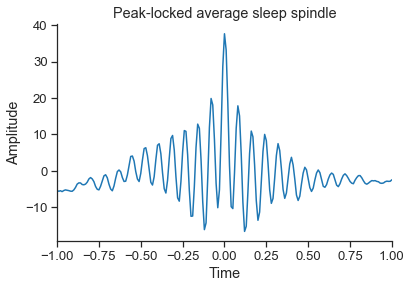

In [5]:
# Plot the peak-locked sleep spindle average across all detected spindles in NEM for this participant
events.groupby("Time")['Amplitude'].mean().plot(color=['tab:blue'])
plt.ylabel('Amplitude')
plt.title("Peak-locked average sleep spindle")
sns.despine()

**Slow oscillations amplitude**

In [6]:
# Filter slow-oscillations
data_so = mne.filter.filter_data(data, sf, 0.1, 1.25, verbose=0, h_trans_bandwidth=0.1, l_trans_bandwidth=0.1)

# Get filtered SO data centered around the most prominent peak of each spindle
events_so = yasa.get_sync_events(data_so, sf, detection=sp, center='Peak', time_before=1, time_after=1)
events = events.merge(events_so, on=['Time', 'Event'], suffixes=['_sp', '_so'])
events.rename(columns={'Amplitude_sp': 'Spindles', 'Amplitude_so': 'SO'}, inplace=True)

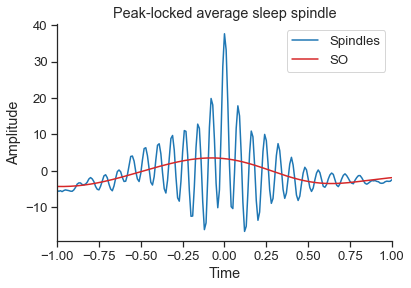

In [7]:
# Overlay spindles + slow-oscillations
events.groupby("Time").mean().plot(color=['tab:blue', 'tab:red'])
plt.ylabel('Amplitude')
plt.title("Peak-locked average sleep spindle")
sns.despine()

**Slow-oscillations phase**

In [8]:
from scipy.fftpack import next_fast_len
from scipy.signal import hilbert

# Extract instantaneous phase using Hilbert transform
n = data_so.size
nfast = next_fast_len(n)
analytic = hilbert(data_so, N=nfast)[:n]
inst_phase = np.angle(analytic)

# Get SO phase centered around the most prominent peak of each spindle
events_phase = yasa.get_sync_events(inst_phase, sf, detection=sp, center='Peak', time_before=1, time_after=1)
events_phase.rename(columns={'Amplitude': "SO_phase"}, inplace=True)
events = events.merge(events_phase, on=['Time', 'Event'])
events.head()

,Time,Event,Spindles,SO,SO_phase
0,-1.00,0,-26.614866,-13.393822,-2.627925
1,-0.99,0,-26.710604,-12.862176,-2.604123
2,-0.98,0,-29.008289,-12.336220,-2.581127
3,-0.97,0,-21.062124,-11.818120,-2.559007
4,-0.96,0,-21.445072,-11.309553,-2.537843


In [9]:
# Find the average phase (in radians) at spindles most prominent peak
events.groupby("Time").mean().loc[0., "SO_phase"]

0.07978956757566986